In [226]:
import pandas as pd
df = pd.read_csv("../3_Analysis_on_Extracted_Data/tracking_features_with_labels.csv")
df.head()

tracking_id  num_points     bbox_area  point_density  avg_segment_distance  \
0            7        1893  1.657872e+08       0.000011             62.014453   
1            8        1752  3.410895e+07       0.000051             41.602138   
2           11        1224  4.864727e+08       0.000003             69.604793   
3           12        2091  1.591802e+08       0.000013             66.382378   
4           15        1587  7.233978e+08       0.000002             80.415227   

   straightness  mean_heading_change      duration      length  cluster  \
0      0.118644             0.507563  299460000000  118.952195        2   
1      0.070770             0.646714  346740000000   75.038270        1   
2      0.360045             0.563577  208300000000   86.281243        3   
3      0.010805             0.558058  355540000000  140.722367        2   
4      0.204191             0.539375  340810000000  128.919145        3   

       pca1      pca2 predicted_label  
0  1.243669  0.183957            TOWN  
1 -1.613260 -0.452885        SUBURBAN  
2  4.270783  3.525632           RURAL  
3  1.205754 -1.590416            TOWN  
4  6.606417  0.169352           RURAL

In [227]:
from sklearn.model_selection import train_test_split
features = df.drop(columns=["tracking_id", "cluster", "predicted_label", "pca1", "pca2"])
labels = df["predicted_label"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=1/3, random_state=42)

In [228]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)




Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.0s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=20

In [229]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

test_indices = X_test.index
df_test = df.loc[test_indices].copy()
df_test["predicted_label"] = y_pred
df_test.to_csv("test_set_with_predictions.csv", index=False)
print("Test set with predictions saved to 'test_set_with_predictions.csv'")

Classification Report:
              precision    recall  f1-score   support

       RURAL       0.98      0.97      0.98       939
    SUBURBAN       0.99      0.99      0.99      7538
        TOWN       0.98      0.98      0.98      4357
       URBAN       0.98      0.99      0.98      1829

    accuracy                           0.98     14663
   macro avg       0.98      0.98      0.98     14663
weighted avg       0.98      0.98      0.98     14663

Confusion Matrix:
[[ 911    2   26    0]
 [   4 7438   69   27]
 [  12   79 4260    6]
 [   0   20    4 1805]]
Test set with predictions saved to 'test_set_with_predictions.csv'


In [230]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1-score:", f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.9830184818932006
Macro F1-score: 0.9812642911090109
Weighted F1-score: 0.9830155917785378


In [231]:
from sklearn.metrics import cohen_kappa_score
print("Cohen’s Kappa:", cohen_kappa_score(y_test, y_pred))


Cohen’s Kappa: 0.9729449446299362


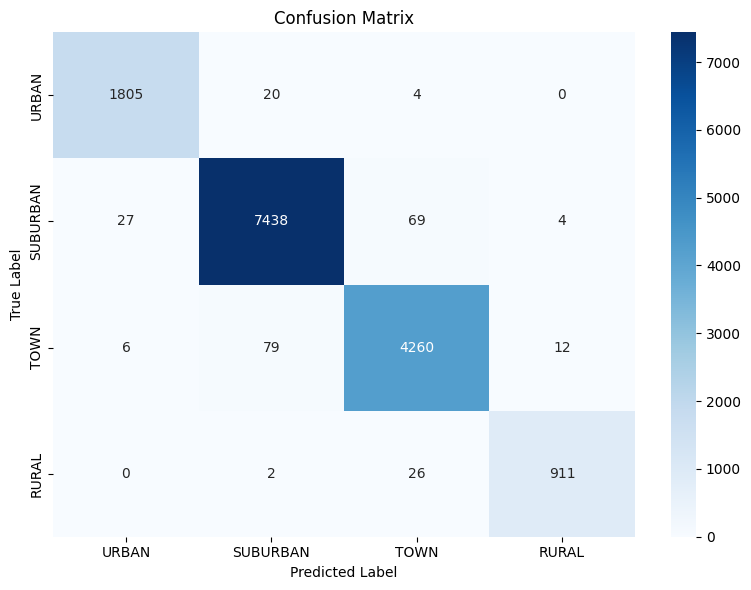

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_order = ["URBAN", "SUBURBAN", "TOWN", "RURAL"]

cm = confusion_matrix(y_test, y_pred, labels=label_order)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_order, yticklabels=label_order)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("../../Thesis/Text/Figures/classifier/confusion_matric_label_prediction.png", dpi=300)
plt.show()

In [233]:
import joblib
joblib.dump(best_clf, "rf_area_classifier_full.pkl")


['rf_area_classifier_full.pkl']

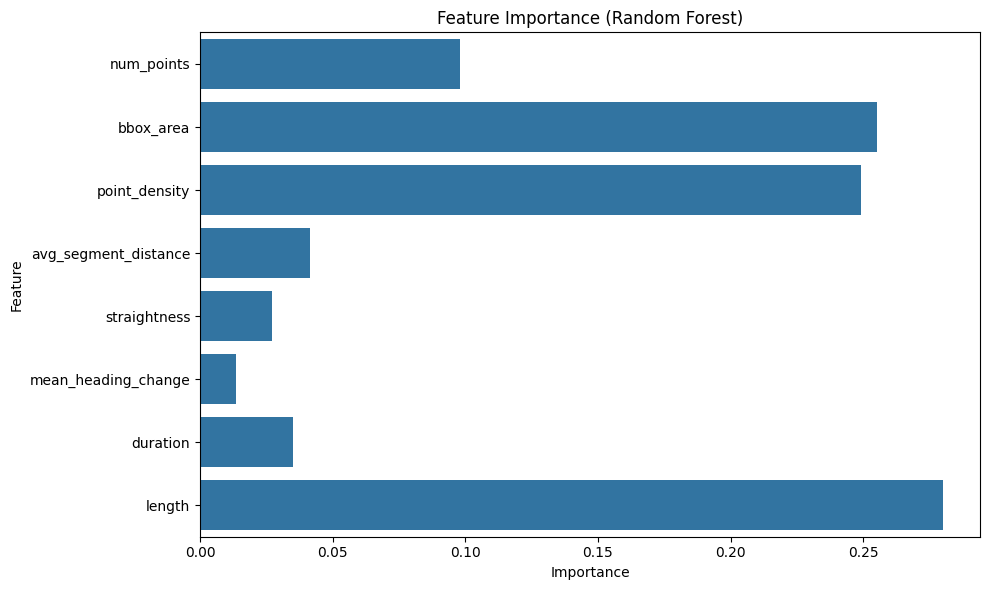

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

clf = joblib.load("rf_area_classifier_full.pkl")

importances = clf.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../../Thesis/Text/Figures/classifier/feature_importance_random_forest.png", dpi=300)

plt.show()


/tmp/ipykernel_992/2735842239.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette=label_palette)


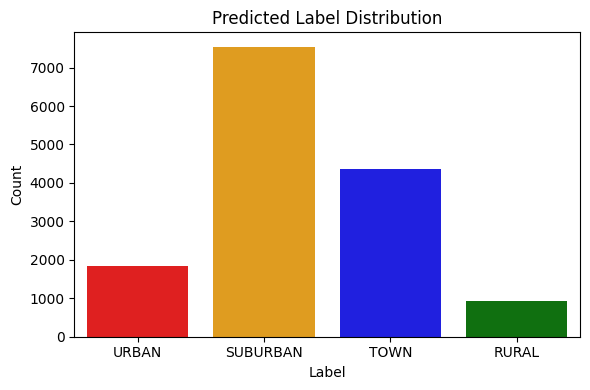

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

label_palette = {
    "URBAN": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "RURAL": "green"
}

pred_label_counts = pd.Series(y_pred).value_counts().reindex(label_order, fill_value=0)

plt.figure(figsize=(6, 4))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette=label_palette)
plt.title("Predicted Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../../Thesis/Text/Figures/classifier/predicted_label_distribution.png", dpi=300)

plt.show()

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


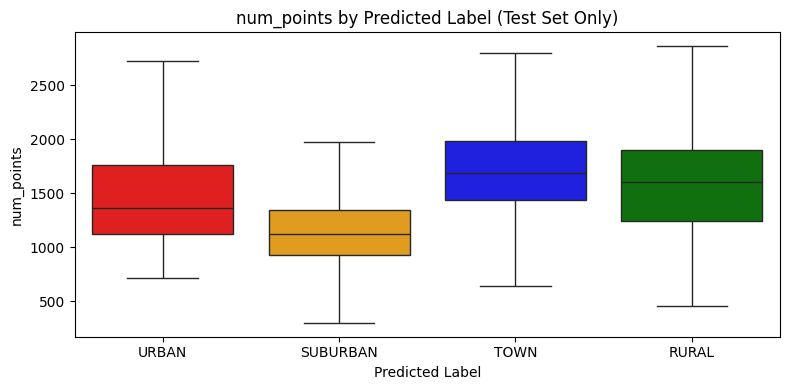

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


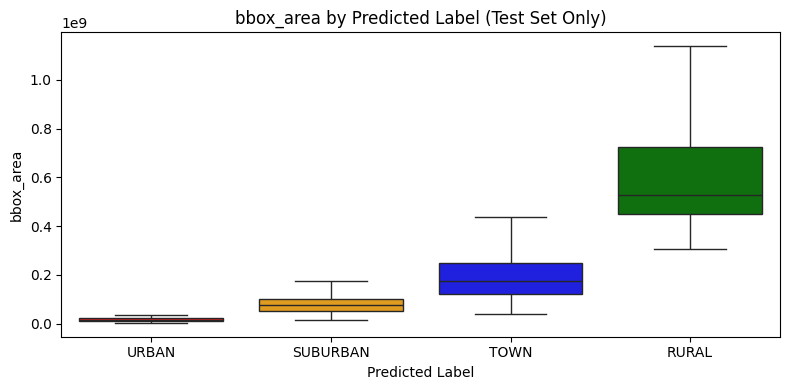

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


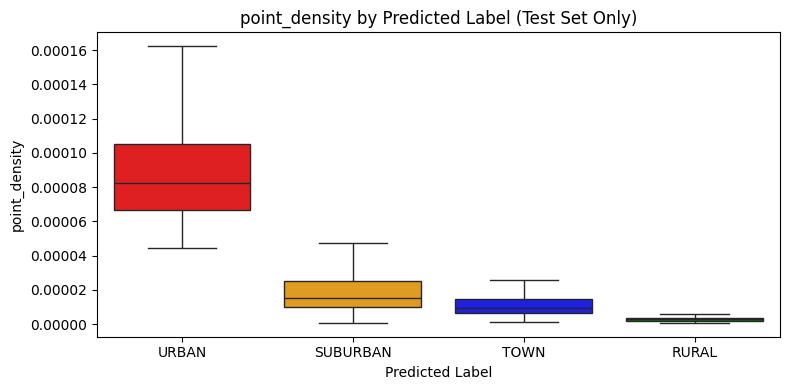

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


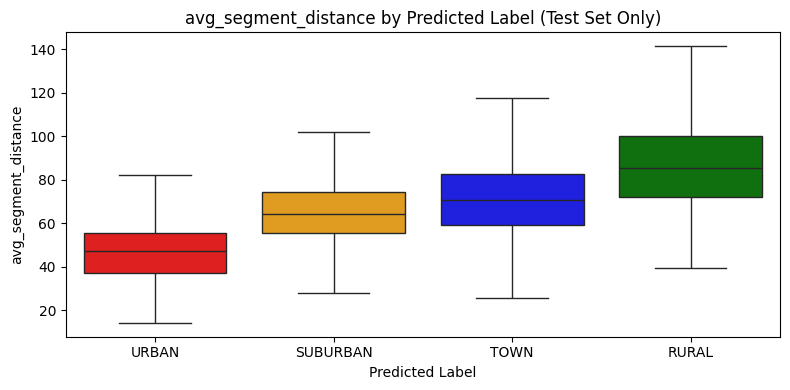

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


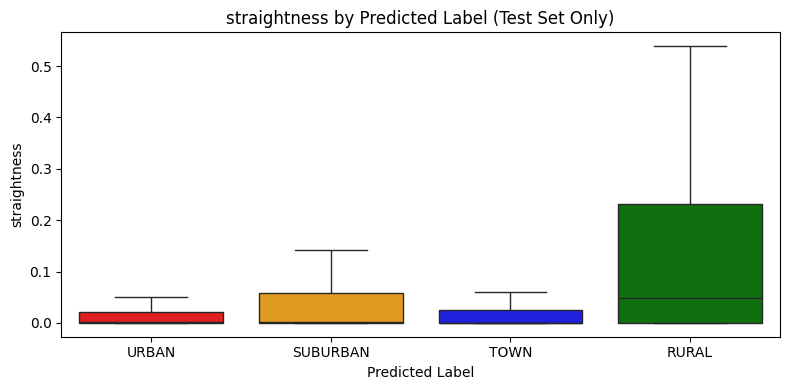

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


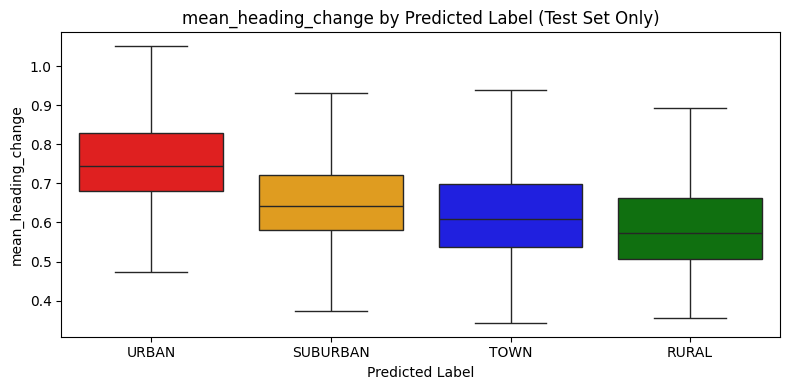

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


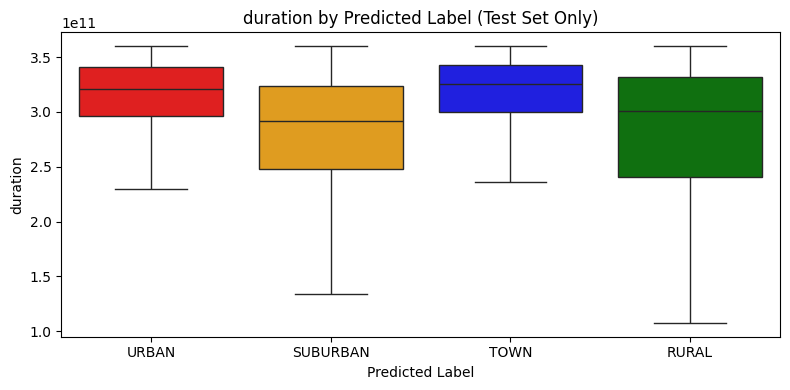

/tmp/ipykernel_992/3924287445.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)


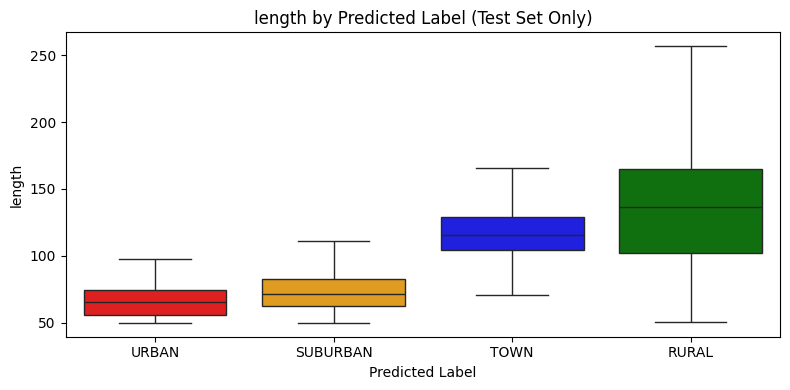

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_test_plot = X_test.copy()
X_test_plot["predicted_label"] = y_pred
X_test_plot["true_label"] = y_test

label_order = ["URBAN", "SUBURBAN", "TOWN", "RURAL"]
features_to_plot = [
    "num_points", "bbox_area", "point_density", "avg_segment_distance",
    "straightness", "mean_heading_change", "duration", "length"
]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=X_test_plot, x="predicted_label", y=feature, showfliers=False, palette=label_palette, order=label_order)
    plt.title(f"{feature} by Predicted Label (Test Set Only)")
    plt.xlabel("Predicted Label")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.savefig(f"../../Thesis/Text/Figures/classifier/boxplots/classifier_{feature}_boxplot.png", dpi=300)
    plt.show()

In [237]:
print(df.head())

   tracking_id  num_points     bbox_area  point_density  avg_segment_distance  \
0            7        1893  1.657872e+08       0.000011             62.014453   
1            8        1752  3.410895e+07       0.000051             41.602138   
2           11        1224  4.864727e+08       0.000003             69.604793   
3           12        2091  1.591802e+08       0.000013             66.382378   
4           15        1587  7.233978e+08       0.000002             80.415227   

   straightness  mean_heading_change      duration      length  cluster  \
0      0.118644             0.507563  299460000000  118.952195        2   
1      0.070770             0.646714  346740000000   75.038270        1   
2      0.360045             0.563577  208300000000   86.281243        3   
3      0.010805             0.558058  355540000000  140.722367        2   
4      0.204191             0.539375  340810000000  128.919145        3   

       pca1      pca2 predicted_label  
0  1.243669  0.183957 

num_points  bbox_area  point_density  avg_segment_distance  \
predicted_label                                                               
URBAN              0.627376   0.000000       1.000000              0.000000   
SUBURBAN           0.000000   0.110124       0.178193              0.467376   
TOWN               1.000000   0.291846       0.098194              0.601268   
RURAL              0.753328   1.000000       0.000000              1.000000   

                 straightness  mean_heading_change  duration    length  
predicted_label                                                         
URBAN                0.000000             1.000000  0.937915  0.000000  
SUBURBAN             0.222001             0.410119  0.000000  0.092205  
TOWN                 0.113786             0.245387  1.000000  0.749067  
RURAL                1.000000             0.000000  0.023722  1.000000

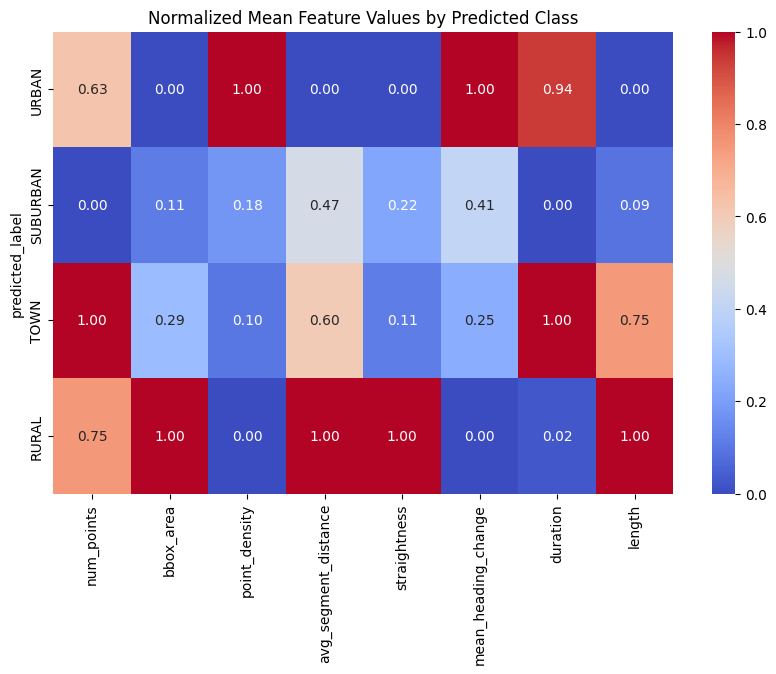

In [238]:
from sklearn.preprocessing import MinMaxScaler

mean_diff = df_test.groupby("predicted_label")[features.columns].mean()

scaler = MinMaxScaler()
mean_diff_scaled = pd.DataFrame(
    scaler.fit_transform(mean_diff),
    columns=mean_diff.columns,
    index=mean_diff.index
)

label_order = ["URBAN", "SUBURBAN", "TOWN", "RURAL"]
mean_diff_scaled = mean_diff_scaled.reindex(label_order)

display(mean_diff_scaled)

plt.figure(figsize=(10, 6))
sns.heatmap(mean_diff_scaled, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Normalized Mean Feature Values by Predicted Class")
plt.savefig("../../Thesis/Text/Figures/classifier/feature_values_normalized.png", dpi=300)
plt.show()


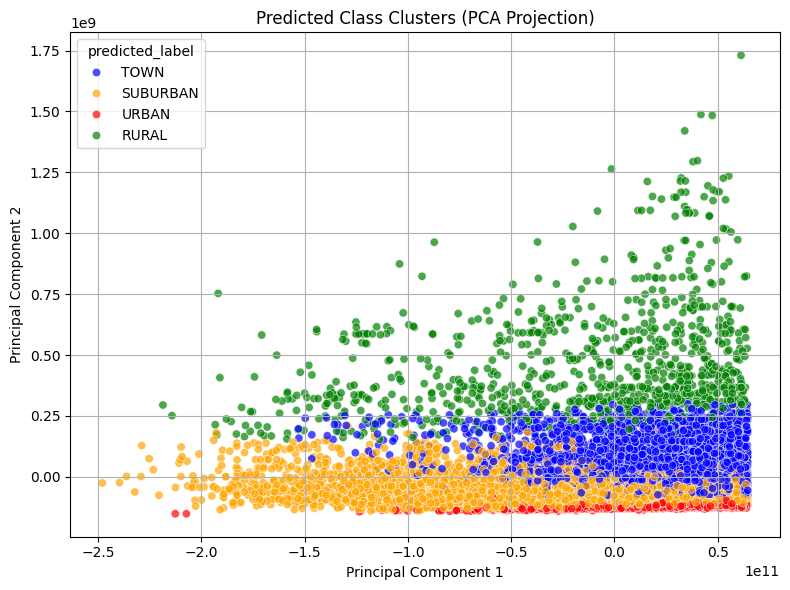

In [239]:
from sklearn.decomposition import PCA
label_palette = {
    "URBAN": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "RURAL": "green"
}

X_vis = PCA(n_components=2).fit_transform(X_test)

df_vis = pd.DataFrame(X_vis, columns=["pca1", "pca2"])
df_vis["predicted_label"] = y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_vis, x="pca1", y="pca2", hue="predicted_label", palette=label_palette, alpha=0.7)
plt.title("Predicted Class Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("../../Thesis/Text/Figures/classifier/pca_projection_test_set.png", dpi=300)
plt.show()


In [240]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_test, df_test["predicted_label"])
print(f"Silhouette Score for K-Means clustering: {score:.4f}")


Silhouette Score for K-Means clustering: -0.1393


Generating SHAP summary plot for all classes...


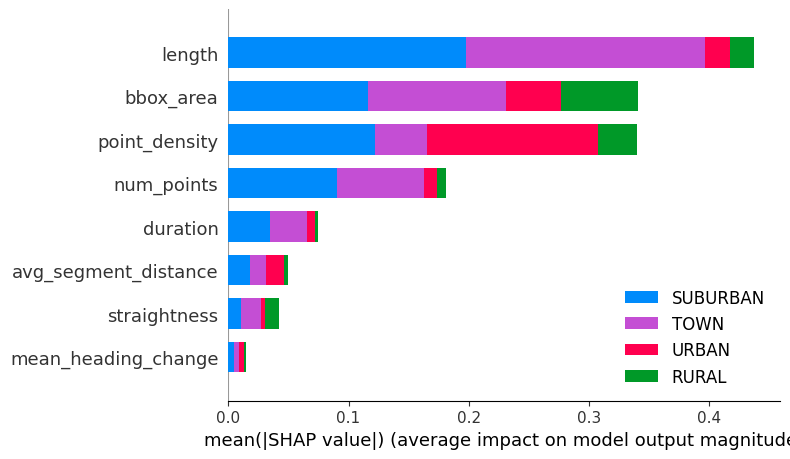

<Figure size 640x480 with 0 Axes>

In [241]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_train)

print("Generating SHAP summary plot for all classes...")
shap.summary_plot(
    shap_values,
    X_train,
    plot_type="bar", 
    class_names=best_clf.classes_,
    feature_names=X_train.columns,
    show=False
)

plt.savefig("../../Thesis/Text/Figures/classifier/shap_summary_for_all_classes.png", dpi=300)
plt.show()
plt.clf()


Generating SHAP summary plot for class: 'RURAL'


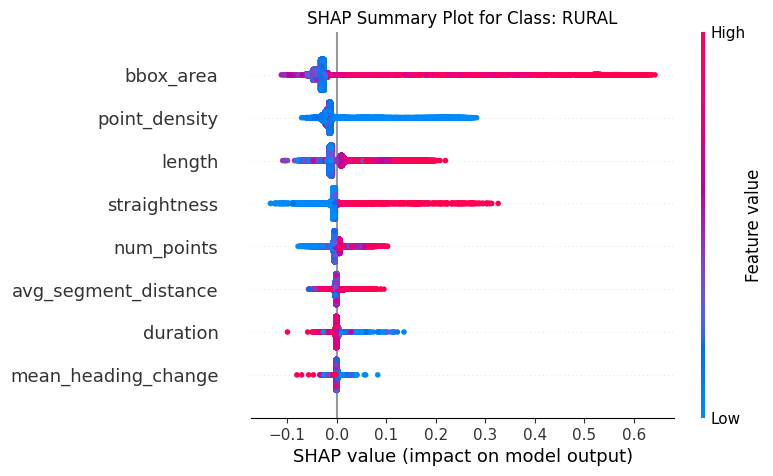

Generating SHAP summary plot for class: 'SUBURBAN'


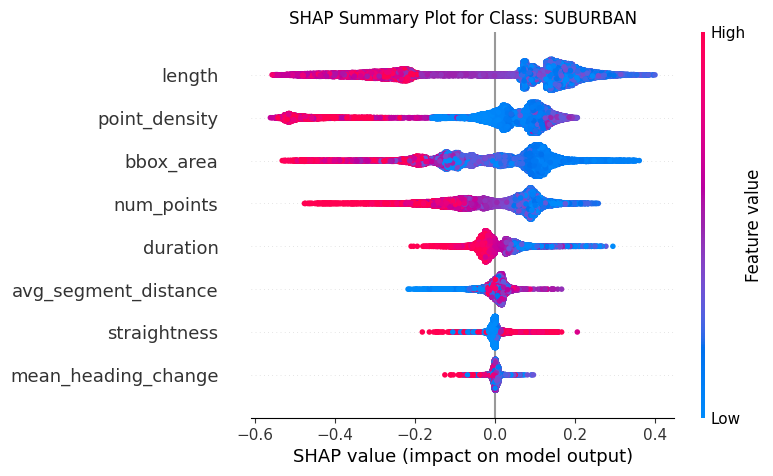

Generating SHAP summary plot for class: 'TOWN'


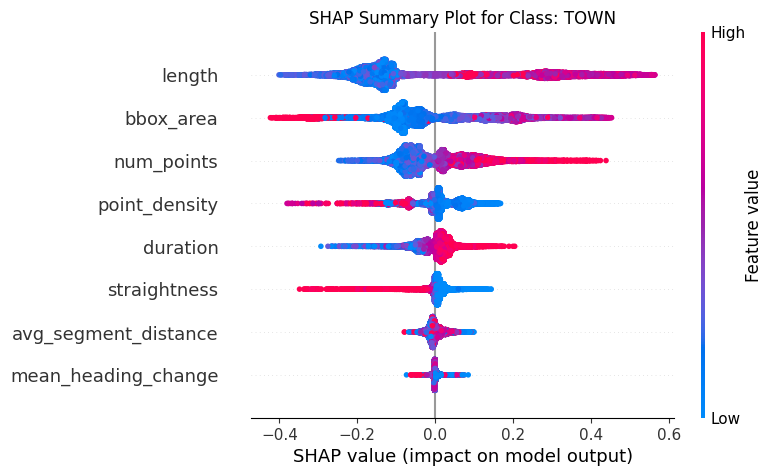

Generating SHAP summary plot for class: 'URBAN'


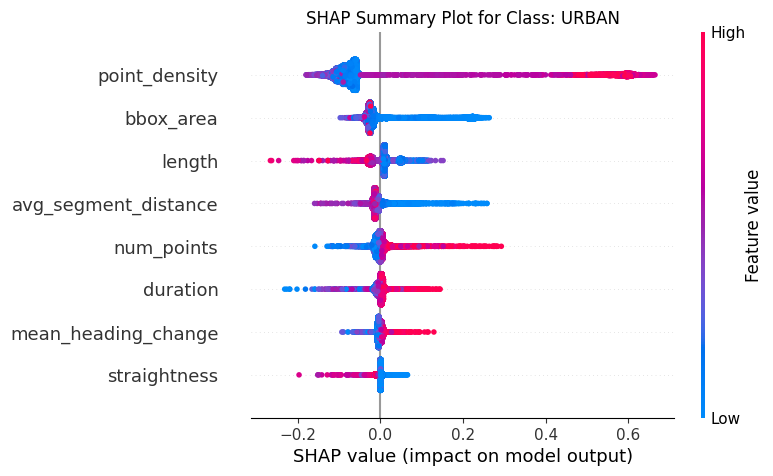

In [242]:
import shap
import matplotlib.pyplot as plt

for i, class_name in enumerate(best_clf.classes_):
    print(f"Generating SHAP summary plot for class: '{class_name}'")
    shap_values_for_one_class = shap_values[:, :, i]

    shap.summary_plot(shap_values_for_one_class, X_train, show=False)
    
    plt.title(f"SHAP Summary Plot for Class: {class_name}")
    plt.savefig(f"../../Thesis/Text/Figures/classifier/shap/shap_summary_for_{class_name}.png", dpi=300)
    plt.show()

/tmp/ipykernel_992/1234536363.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=trackings_per_group, random_state=42))["tracking_id"]


[32800, 18523, 10106, 3764, 46977, 17546, 43509, 60595, 35896, 13703, 94357, 12601, 66080, 58873, 63410, 65877]


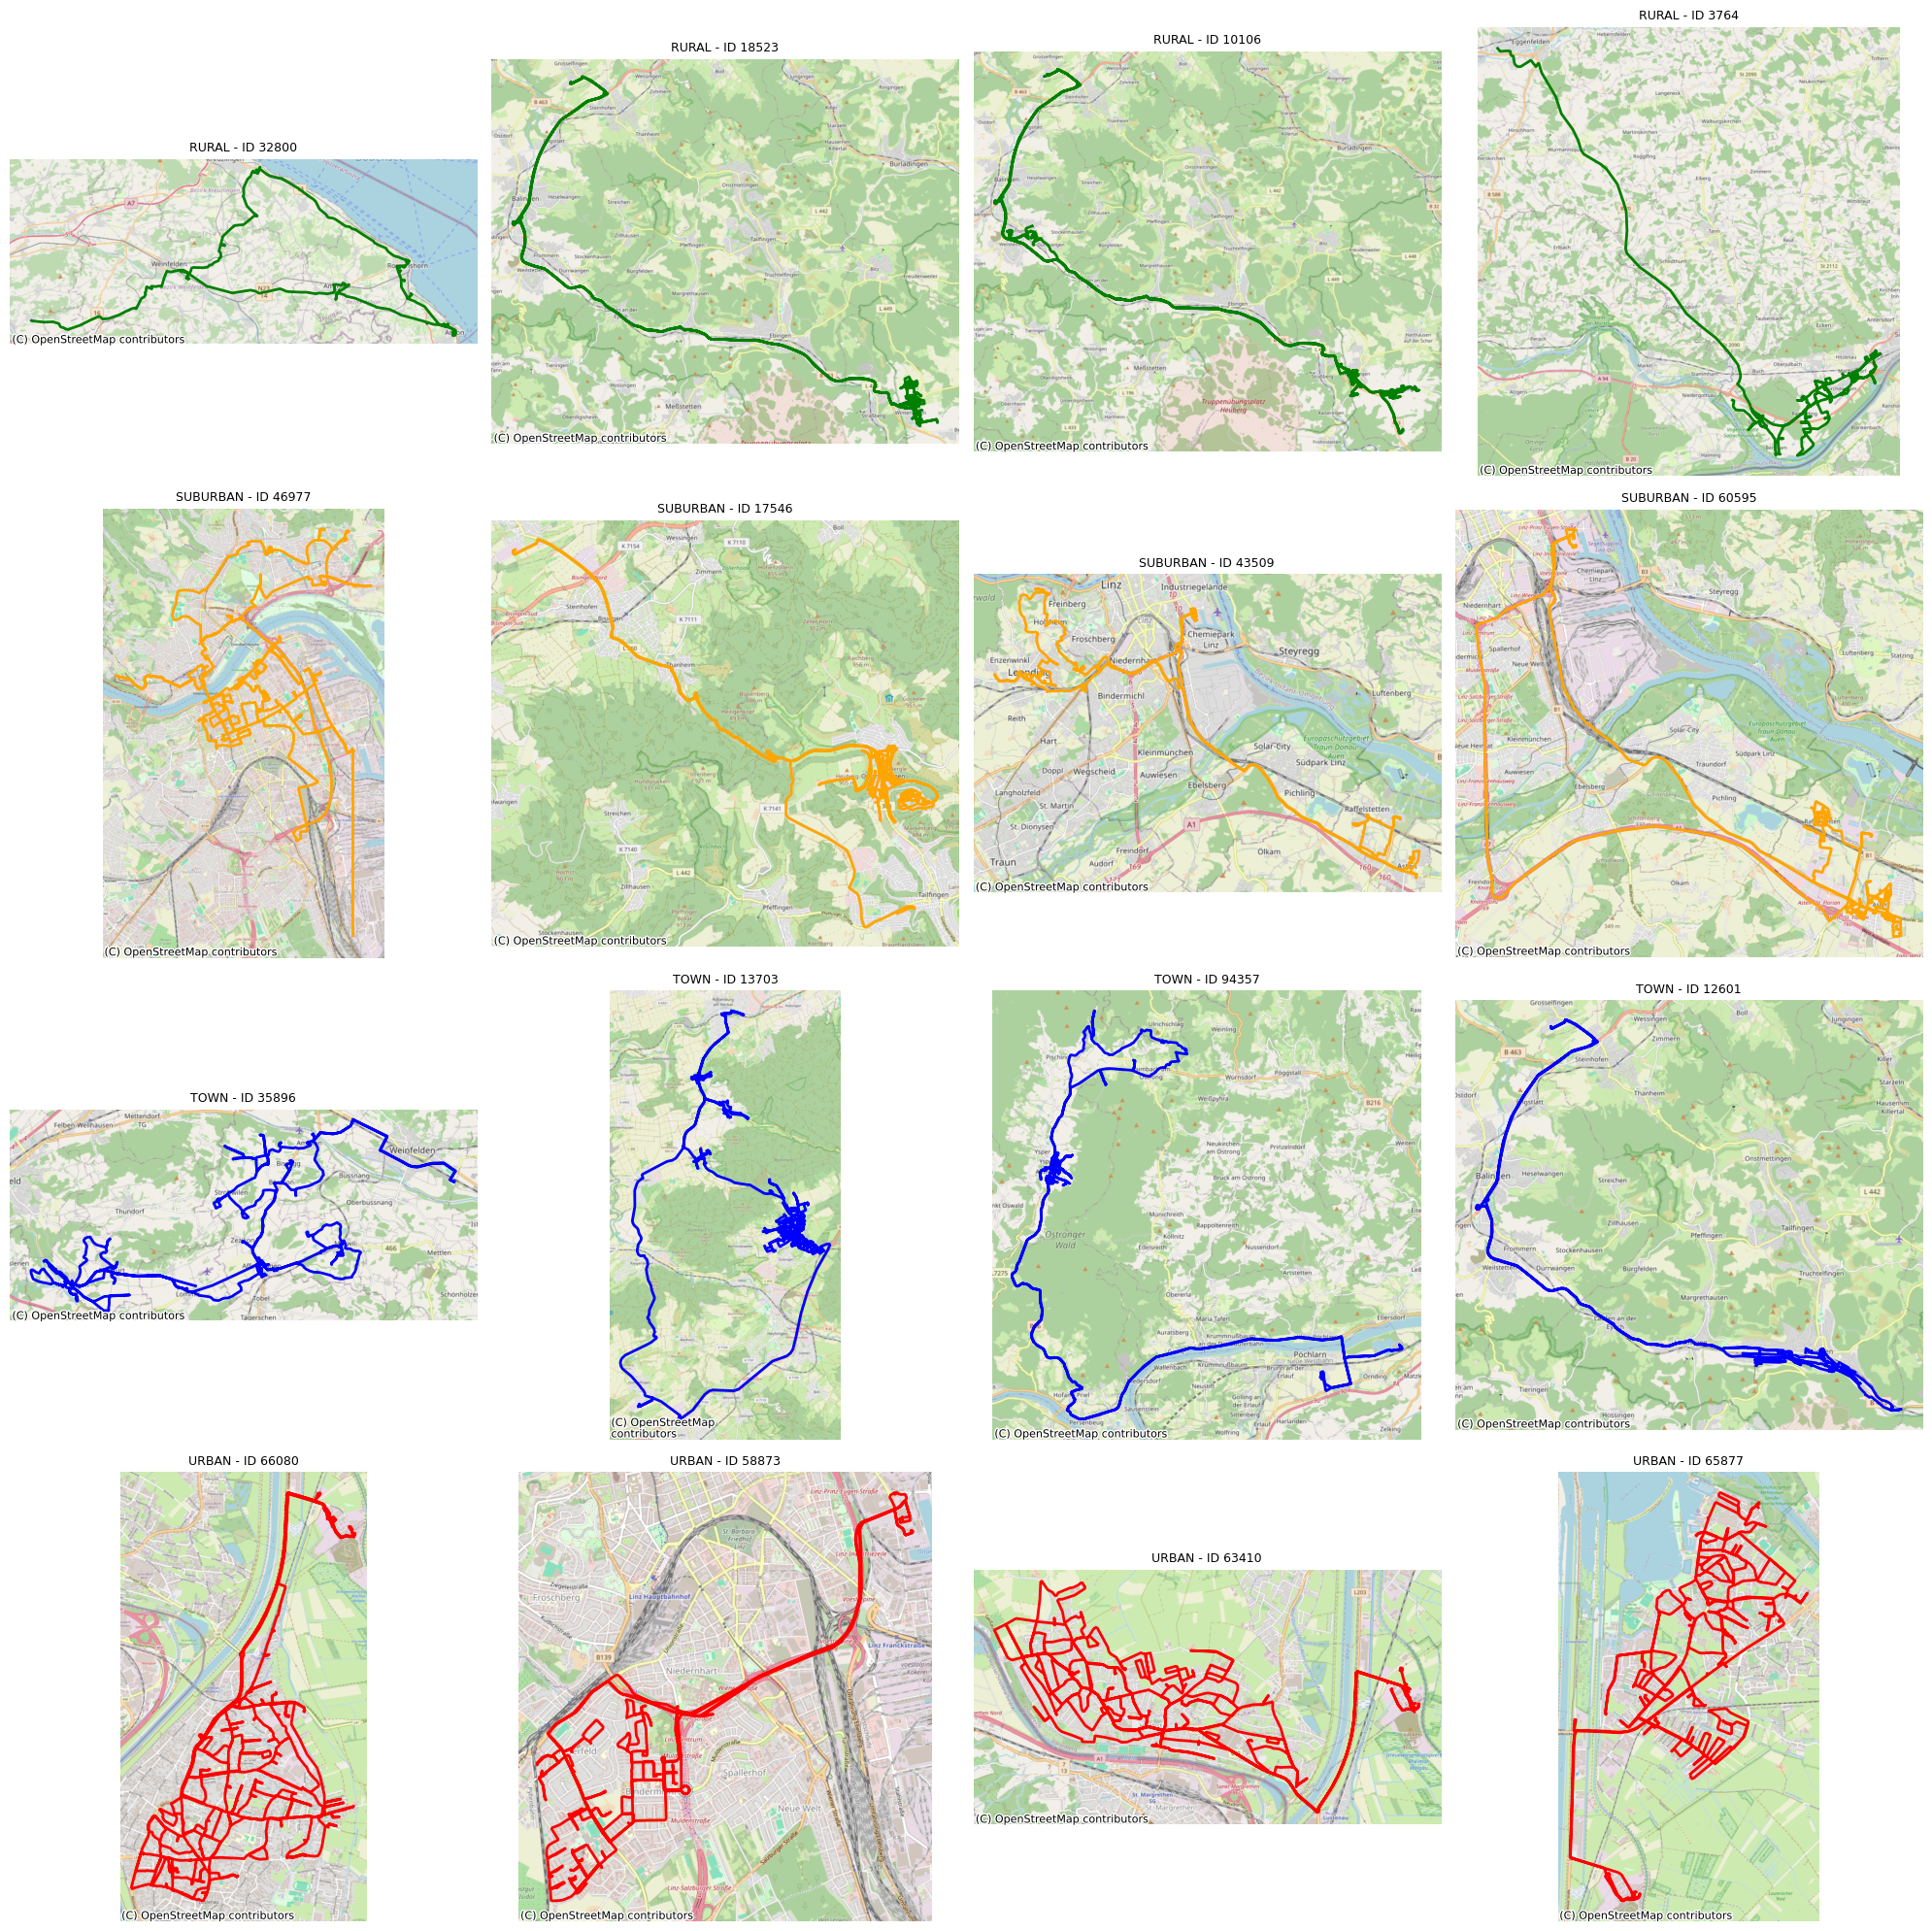

In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
import pyarrow.parquet as pq

# Load predictions (small file)
predicted_df = pd.read_csv("test_set_with_predictions.csv")

trackings_per_group = 4

# Sample 2 IDs per predicted label
sampled_ids = (
    predicted_df.groupby("predicted_label")
    .apply(lambda x: x.sample(n=trackings_per_group, random_state=42))["tracking_id"]
    .explode()
    .tolist()
)

print(sampled_ids)

# Efficiently load only the required trackings from large Parquet file
table = pq.read_table(
    "../Data_Preperation/filtered_data_full_1.parquet",
    filters=[("id_tracking", "in", sampled_ids)]
)
sampled_routes = table.to_pandas()

# Plotting
fig, axes = plt.subplots(trackings_per_group, 4, figsize=(20, 20))
axes = axes.flatten()

color_map = {
    "URBAN": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "RURAL": "green",
}

for i, tracking_id in enumerate(sampled_ids):
    ax = axes[i]
    route = sampled_routes[sampled_routes["id_tracking"] == tracking_id].sort_values("sequence")
    coords = list(zip(route["longitude"], route["latitude"]))
    label = predicted_df[predicted_df["tracking_id"] == tracking_id]["predicted_label"].values[0]

    if len(coords) < 2:
        continue

    line = LineString(coords)
    gdf = gpd.GeoDataFrame(index=[0], geometry=[line], crs="EPSG:4326").to_crs(epsg=3857)

    gdf.plot(ax=ax, color=color_map.get(label, "gray"), linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{label} - ID {tracking_id}", fontsize=9)
    ax.set_axis_off()

# Hide any unused subplots
for j in range(len(sampled_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("../../Thesis/Text/Figures/classifier/four_final_predictions_per_class.png", dpi=300)
plt.show()



In [244]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(clf, features, labels, cv=skf, scoring="accuracy")

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", np.mean(scores))
print("Std Dev:", np.std(scores))


Cross-Validation Scores: [0.98340532 0.98363264 0.98658786 0.98522391 0.98204137 0.98590589
 0.98681519 0.98476927 0.98681219 0.98590268]
Mean Accuracy: 0.9851096320725254
Std Dev: 0.0015454778809685821
